# Load Data

In [1]:
save_plots = False

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import special
from inspect import signature
from datetime import datetime
import time
from tqdm import tqdm
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as md

In [3]:
## Set plot styles

%matplotlib inline
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.linewidth'] = 0.75 #set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['legend.fontsize'] =5
matplotlib.rcParams['pdf.fonttype']=42


matplotlib.rcParams['figure.figsize'] = (3.4908516673585166, 2.327234444905678)
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rc('font', size= 7)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

/home/alex/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [4]:
! ls /home/alex/PhD/Gator/Data/Calibrations_2021_02
#! ls /home/alex/PhD/Gator/Data/background/Background_2021_02/SPE/

Eu152_20210204_0_000.Spe  Th228_20210204_0_000.Spe  Th228_20210211_0_000.Spe
Eu152_20210204_0_001.Spe  Th228_20210204_0_001.Spe


In [5]:
path = '/home/alex/PhD/Gator/Data/Calibrations_2021_02/'
#files_list = [path+'Th228_20210204_0_001.Spe']
files_list = glob.glob(path+'Th228_20210204*')
filename_suffix_save = 'plots/Th228_20210204'

In [6]:
def load_file(file):
    number_lines_header = 12 ## There are 12 header lines in the SPE file
    counts_list = []

    with open(file) as fp:
        for i, line in enumerate(fp):
            line = line.rstrip('\n')
            if i == 1: ## description of the sample
                descr = line
                #print(descr)
            elif i == 7: ## starting acquisition time
                string_time = line
                #print(string_time)
                # TODO: convert to UNIX time
            elif i == 9: ## acquisition time
                live_time = int(line.split(' ')[0]) ## acquisition live time in seconds (without dead time)
                real_time = int(line.split(' ')[1]) ## acquisition real time in seconds
                #print(live_time, real_time)
            elif i == 11: ## channel numbers
                first_channel = int(line.split(' ')[0]) ## number of first channel, usually 0
                last_channel = int(line.split(' ')[1]) ## number of last channel, usually 16383 (= 2^14-1)
                #print(first_channel, last_channel)
            elif (i >= number_lines_header):
                if (i<=last_channel+number_lines_header):
                    counts_list.append(int(line))
                elif i > last_channel+number_lines_header:
                    break

    channels_list = np.arange(0, last_channel+1)
    df = pd.DataFrame(data={'channel': channels_list, 'counts': counts_list})
    
    return df, live_time, string_time, descr

def load_files(files_list):
    for i_file, file in enumerate(files_list):
        if i_file == 0:
            df_combined, live_time_combined = load_file(file)[0:2]
        else:
            df_temp, live_time_temp = load_file(file)[0:2]
            if len(df_combined) == len(df_temp):
                df_combined.counts = df_combined.counts + df_temp.counts
                live_time_combined = live_time_combined + live_time_temp
            else:
                raise ValueError("file "+str(file)+" has different number of channels compared to previous file")
                
    print('total live time = '+str(live_time_combined)+' s = '+str(live_time_combined/(24*60*60))+' d')
    return df_combined, live_time_combined

In [7]:
df, total_live_time = load_files(files_list)
df

total live time = 3600 s = 0.041666666666666664 d


,channel,counts
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
16379,16379,0
16380,16380,0
16381,16381,0
16382,16382,0


In [8]:
## Trigger Rate [s^-1]
df.loc[545:16380].counts.sum()/total_live_time

4023.811388888889

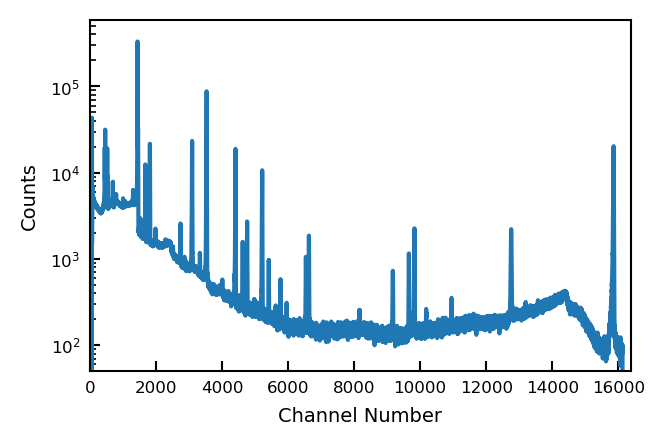

In [9]:
plt.plot(df.channel, df.counts)
plt.yscale('log')
plt.xlim(0,16383)
plt.ylim(bottom = 50)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
plt.show()

# Fit Individual Peaks

In [10]:
def gausFunc(E, Gamma,P,sigma,C):
    gaus = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + C
    return gaus

#def tailFunc(E, Gamma,P,sigma,beta,C):
#    tail = Gamma * np.exp((E-P)/beta)*special.erfc(((E-P)/beta)+(sigma/(np.sqrt(2)*beta))) + C
#    return tail

from scipy.stats import crystalball
def crystalballFunc(E, Gamma,P,sigma,alpha,n,C):
    ## https://scipy.github.io/devdocs/generated/scipy.stats.crystalball.html
    crys = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + C
    return crys

def stepFunc(E, S,P,sigma,C):
    step = S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return step

def linFunc(E, m,q):
    lin = m*E+q
    return lin

def gausStepFunc(E, Gamma,S,P,sigma,C):
    gausStep = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return gausStep

def fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q
    return res

In [11]:
df_calibration = pd.DataFrame(data={'name': [], 'e_lit': [], 'e_err_lit': [], 
                                    'peak_position': [], 'peak_position_unc': [], 
                                    'peak_width': [], 'peak_width_unc': [], 
                                    'chi2_dof': [], 'channel_max': []})

## Pb238

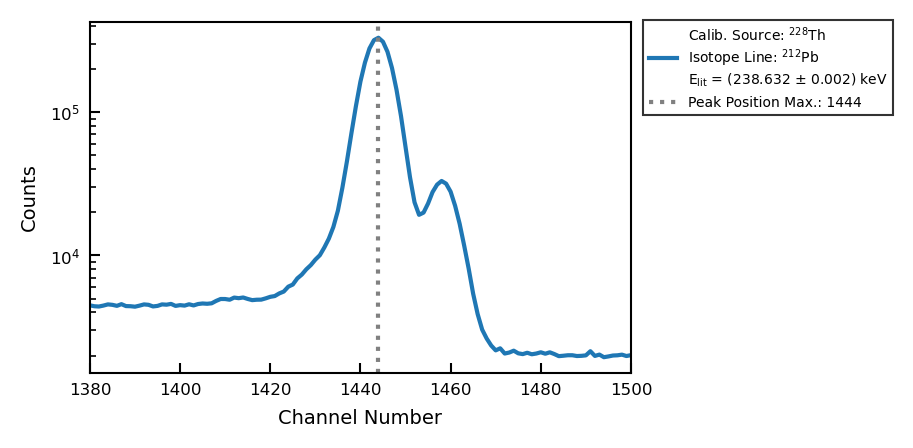

In [12]:
name = 'Pb238'
isotope = '$^{212}$Pb'
e_lit = 238.632 #keV
e_err_lit = 0.002 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1380
upper_channel = 1500
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [13]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,0.1]
limits_q = [-np.inf,+np.inf]

In [14]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 2.47210712e+06  1.44388739e+03  3.34989090e+00  1.80448158e+00
  4.84843772e+00  1.04224312e+03 -9.56879921e-02  2.90422204e+03]


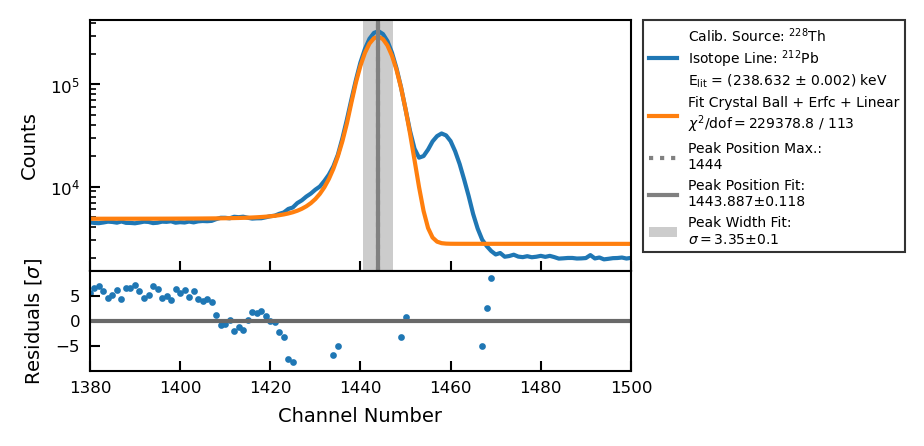

In [15]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
#yticks[-1].label1.set_visible(False)
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

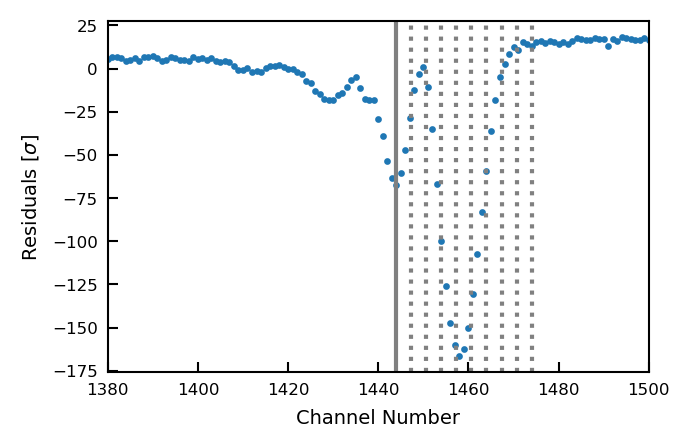

In [16]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
for i in range(1,10):
    plt.axvline(peak_position+i*peak_width, linestyle='dotted', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

**Comment:** little peak from Ra-224 at ~240keV above Pb-212 peak affects the fit -> add additional Gaussian with clever fit constraints.

In [17]:
def fitFunc238(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [18]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,_,_,_ = popt
#guess_sigma = popt[2]

guess_P2 = popt[1] + 5*popt[2]
guess_Gamma2 = (val_max - high_med)/10
guess_sigma2 = popt[2]

limits_P2 = [popt[1] + 3*popt[2], min(popt[1]+7*popt[2], upper_channel)]
limits_Gamma2 = [1, (val_max - high_med)/2]
limits_sigma2 = [0.5, min(2*popt[2], 100,(upper_channel-lower_channel)/2)]

In [19]:
## Total Fit
popt, pcov = curve_fit(fitFunc238, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 2.73269809e+06  1.44383855e+03  3.24988694e+00  1.83079414e+00
  2.61522296e+00  1.15790866e+03 -1.00000000e-01  2.20217039e+03
  3.04673501e+04  1.45793513e+03  3.39075711e+00]
Appending data for Pb238 to df_calibration.


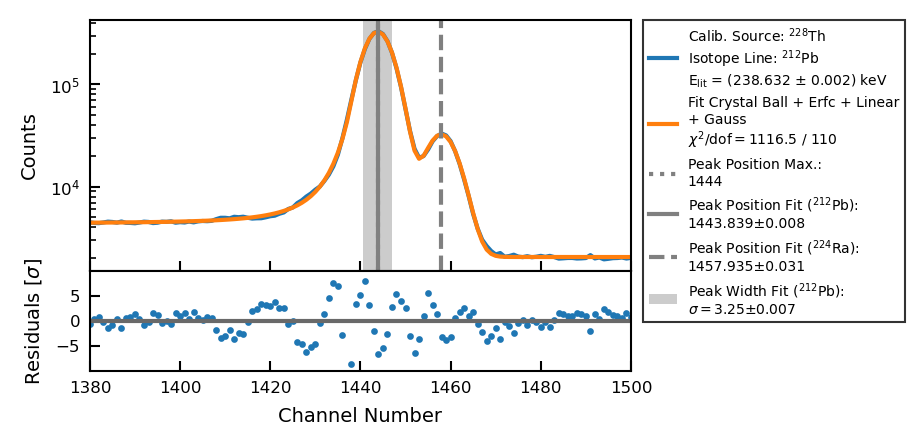

In [20]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc238(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{224}$Ra):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

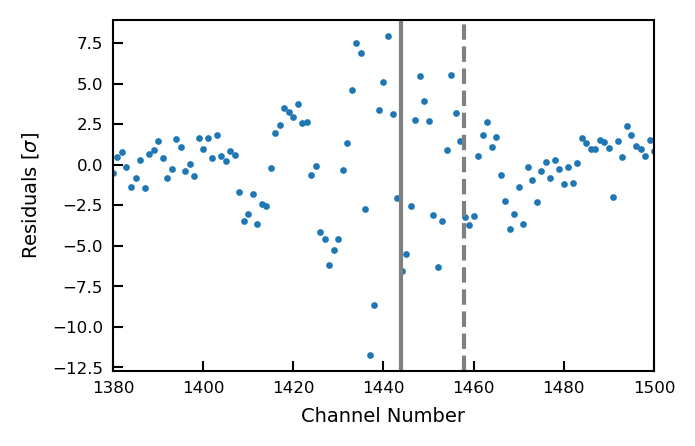

In [21]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
plt.axvline(peak2_position, linestyle='dashed', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

**Comment:** there seems to be a little bump below the main peak as well (what is it?) -> add additional Gaussian with clever fit constraints.

In [22]:
def fitFunc238_2(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2, Gamma3,P3,sigma3):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2))) + (Gamma3 * np.exp(-(E-P3)**2/(2*sigma3**2)))
    return res

In [23]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2 = popt

In [24]:
guess_P3 = popt[1] - 5*popt[2]
guess_Gamma3 = (val_max - low_med/2)/100
guess_sigma3 = popt[2]

limits_P3 = [(lower_channel+popt[1])/2, popt[1] - 2*popt[2]]
limits_Gamma3 = [0, (val_max - (low_med+high_med)/2)/10]
limits_sigma3 = [0.5, min(10*popt[2], 100,(upper_channel-lower_channel)/2)]

In [25]:
## Total Fit
popt, pcov = curve_fit(fitFunc238_2, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2,guess_Gamma3,guess_P3,guess_sigma3], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0],limits_Gamma3[0],limits_P3[0],limits_sigma3[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1],limits_Gamma3[1],limits_P3[1],limits_sigma3[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])
peak3_position = popt[12]
peak3_position_unc = np.sqrt(pcov[12,12])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc238_2(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc238_2(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 2.71539249e+06  1.44384063e+03  3.24786269e+00  1.78643378e+00
  3.48279043e+00  1.22299457e+03 -1.00000000e-01  2.20209100e+03
  3.04635488e+04  1.45793320e+03  3.39246624e+00  1.12538466e+03
  1.42826072e+03  2.52470124e+00]
Entry for Pb238 already in df_calibration, will overwrite it!


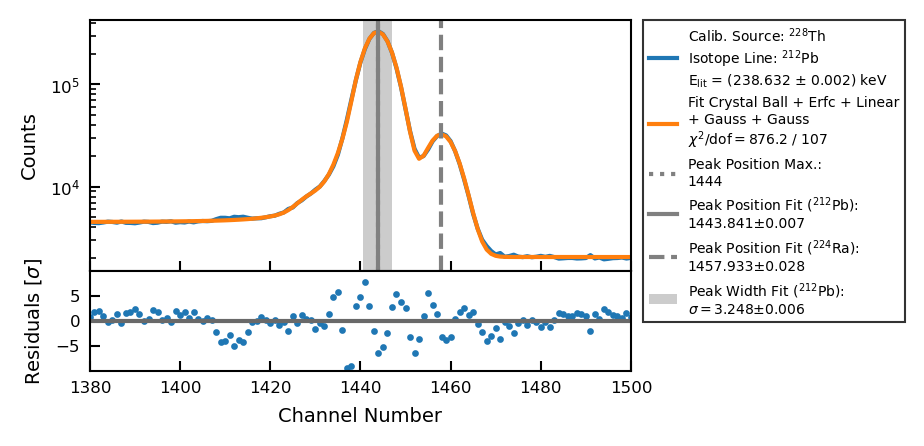

In [26]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc238_2(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss + Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{224}$Ra):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

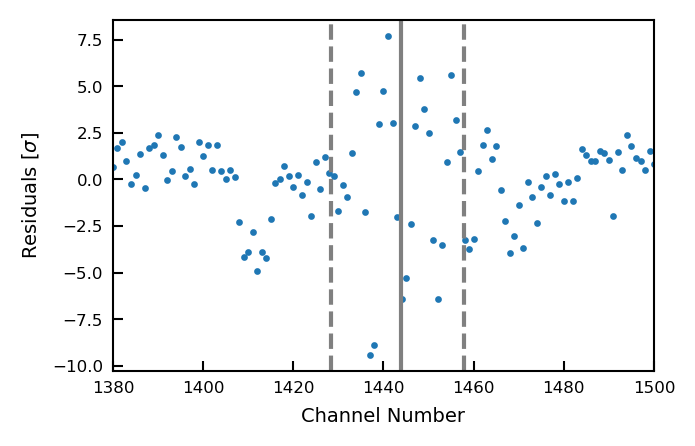

In [27]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
plt.axvline(peak2_position, linestyle='dashed', color = 'gray')
plt.axvline(peak3_position, linestyle='dashed', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

## Tl 277

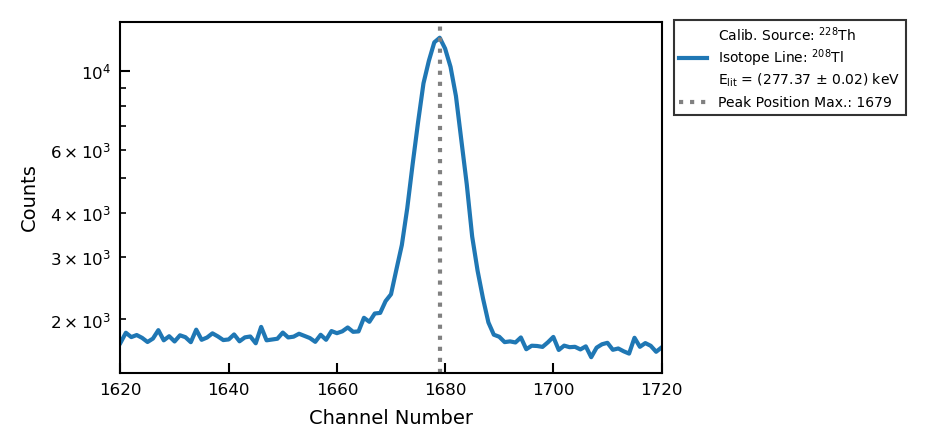

In [28]:
name = 'Tl277'
isotope = '$^{208}$Tl'
e_lit = 277.37 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1620
upper_channel = 1720
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [29]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,0]
limits_q = [-np.inf,+np.inf]

In [30]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 9.24238138e+04  1.67879049e+03  3.32070049e+00  1.68982319e+00
  2.68430566e+00 -6.09731479e+00 -1.39426164e+00  4.06132750e+03]
Appending data for Tl277 to df_calibration.


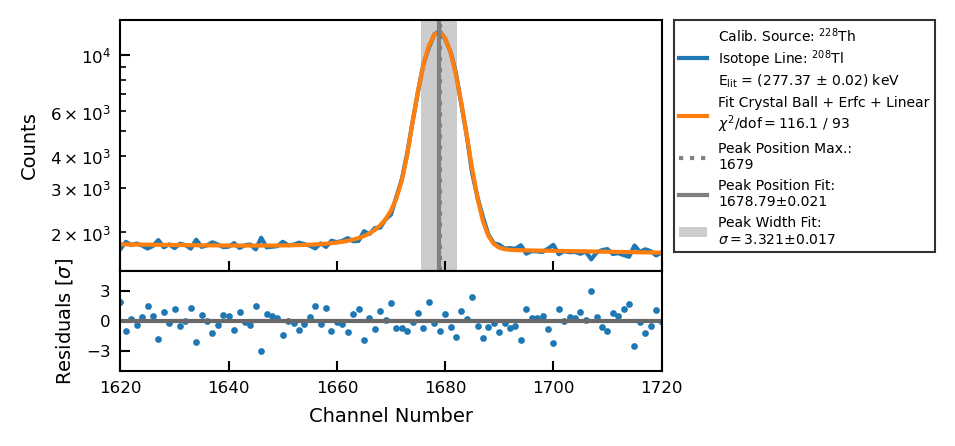

In [31]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Pb 300

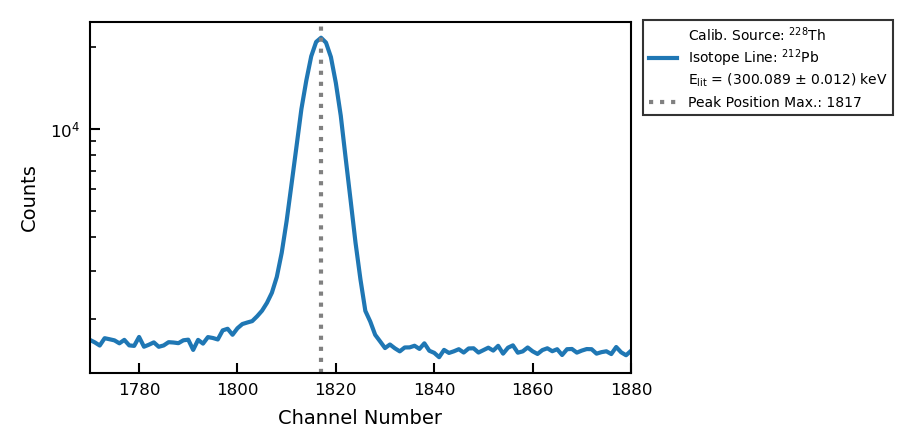

In [32]:
name = 'Pb300'
isotope = '$^{212}$Pb'
e_lit = 300.089 #keV
e_err_lit = 0.012 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1770
upper_channel = 1880
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [33]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [34]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 1.76289802e+05  1.81690462e+03  3.39245829e+00  1.66152935e+00
  3.28974660e+00 -4.57139927e+00 -1.23896023e+00  3.83349362e+03]
Appending data for Pb300 to df_calibration.


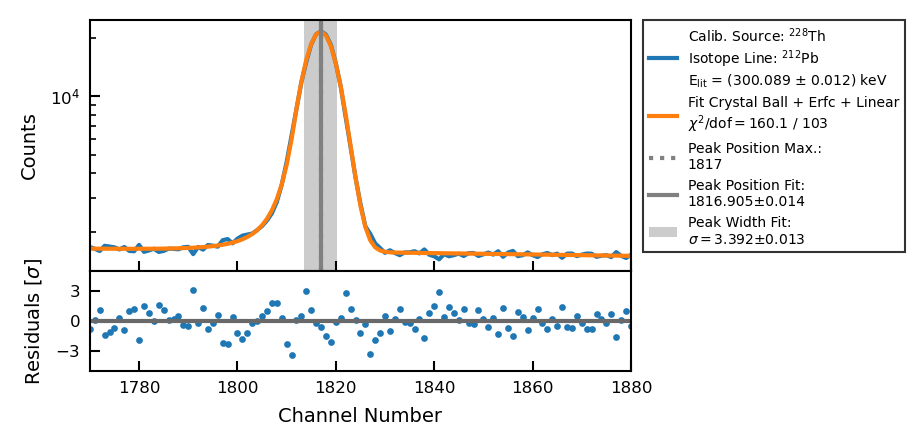

In [35]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 583

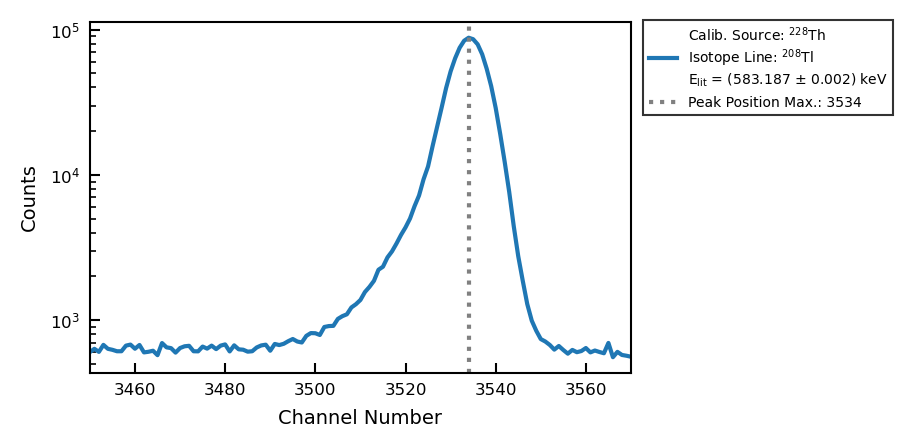

In [36]:
name = 'Tl583'
isotope = '$^{208}$Tl'
e_lit = 583.187 #keV
e_err_lit = 0.002 #keV

#######################
## Adjust these values if necessary:
lower_channel = 3450
upper_channel = 3570
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [37]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [38]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 9.26572799e+05  3.53407452e+03  3.97959790e+00  1.38109674e+00
  3.51746217e+00 -8.25000000e+01 -1.35628240e+00  5.45711434e+03]
Appending data for Tl583 to df_calibration.


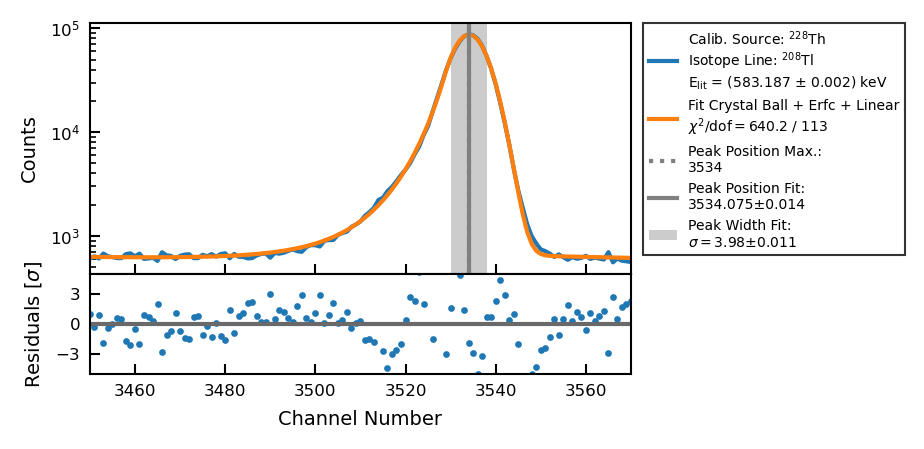

In [39]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 727

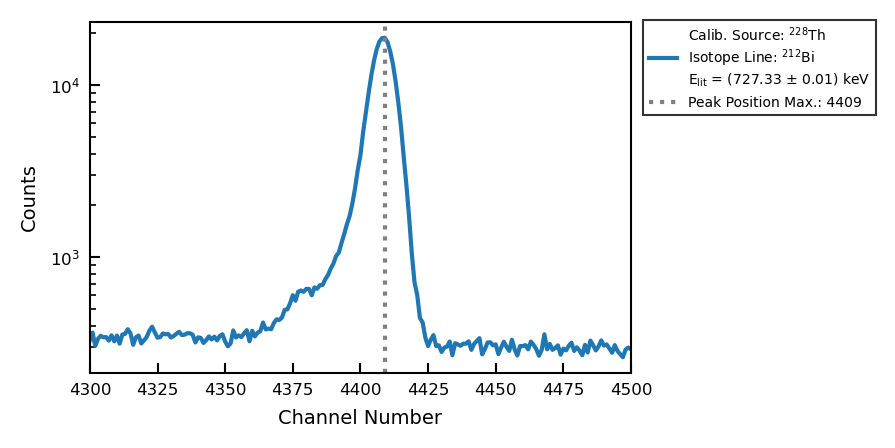

In [40]:
name = 'Bi727'
isotope = '$^{212}$Bi'
e_lit = 727.33 #keV
e_err_lit = 0.01 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4300
upper_channel = 4500
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [41]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [42]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 2.21222165e+05  4.40828515e+03  4.27743779e+00  1.45174535e+00
  2.12996803e+00 -1.60929577e+01 -3.23745455e-01  1.74525888e+03]
Appending data for Bi727 to df_calibration.


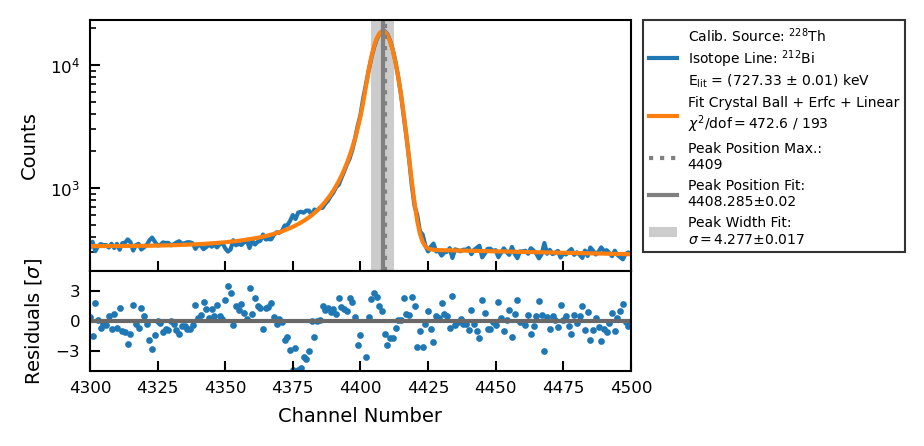

In [43]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

**Comment:** little peak from Tl-208 at ~727keV below Bi-212 peak might slightly affect the fit (deviation maximum position and position from fit > 0.5 bins) -> add additional Gaussian with clever fit constraints.

In [44]:
def fitFunc727(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [45]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q = popt

guess_P2 = popt[1] - 10*popt[2]
guess_Gamma2 = (val_max - (low_med+high_med)/2)/100
guess_sigma2 = popt[2]

limits_P2 = [(lower_channel+popt[1])/2, popt[1] - 2*popt[2]]
limits_Gamma2 = [0, (val_max - (low_med+high_med)/2)/10]
limits_sigma2 = [0.5, min(10*popt[2], 100,(upper_channel-lower_channel)/2)]

In [46]:
## Total Fit
popt, pcov = curve_fit(fitFunc727, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc727(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc727(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 2.13563243e+05  4.40832521e+03  4.24832773e+00  1.29554468e+00
  4.35049325e+00  7.46269981e-01 -2.74060012e-01  1.52388655e+03
  1.87429616e+02  4.37941186e+03  7.10448488e+00]
Entry for Bi727 already in df_calibration, will overwrite it!


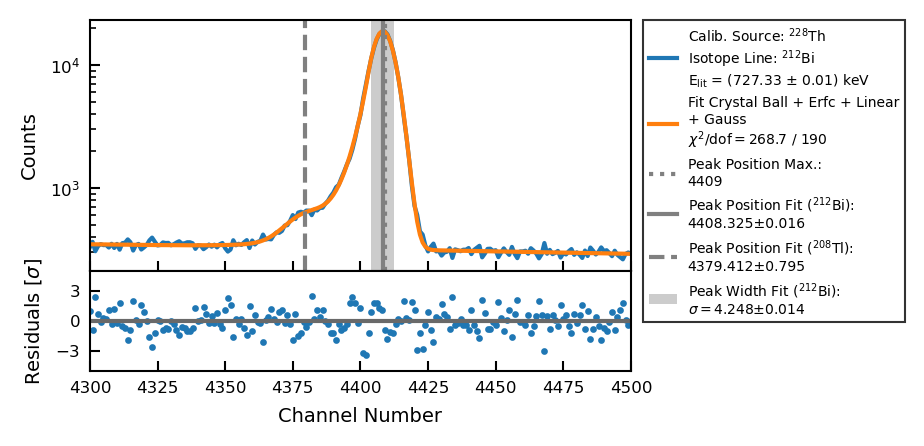

In [47]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc727(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{208}$Tl):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 763

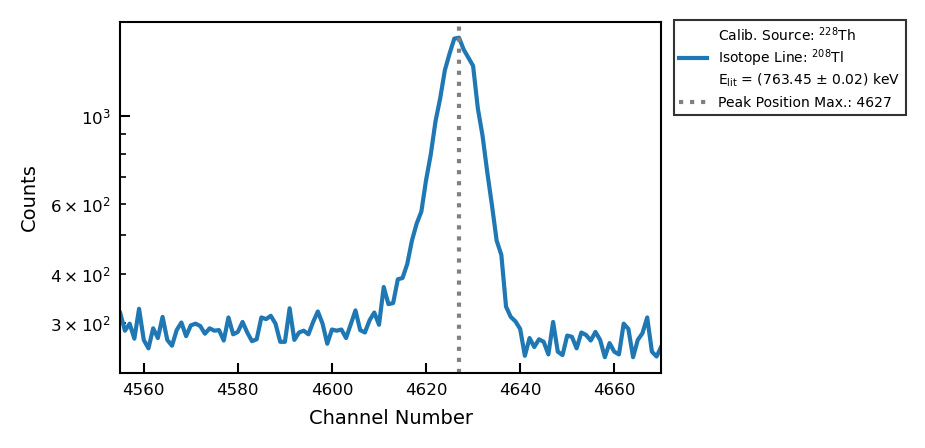

In [48]:
name = 'Bi763'
isotope = '$^{208}$Tl'
e_lit = 763.45 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4555
upper_channel = 4670
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [49]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0# (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,+0.1] #[-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [50]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 1.41723927e+04  4.62675282e+03  4.53194475e+00  1.76648384e+02
  9.91975393e+02  1.75312063e+01  1.00000000e-01 -1.99104107e+02]
Appending data for Bi763 to df_calibration.


/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


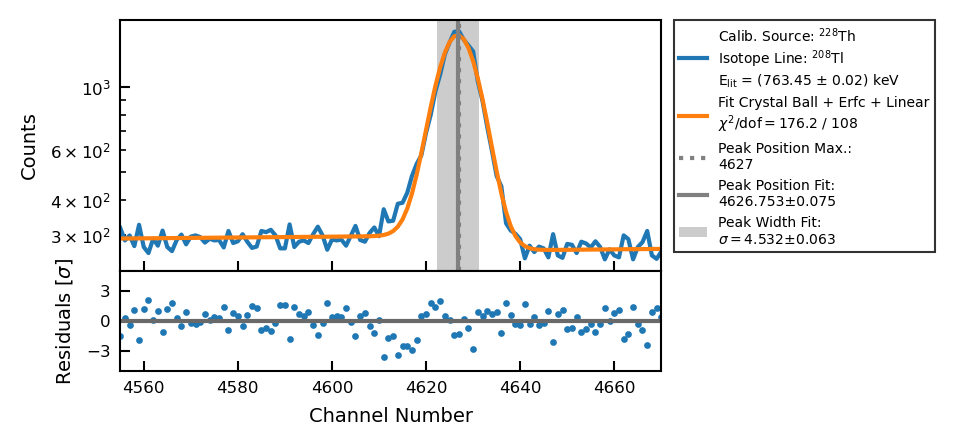

In [51]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 785

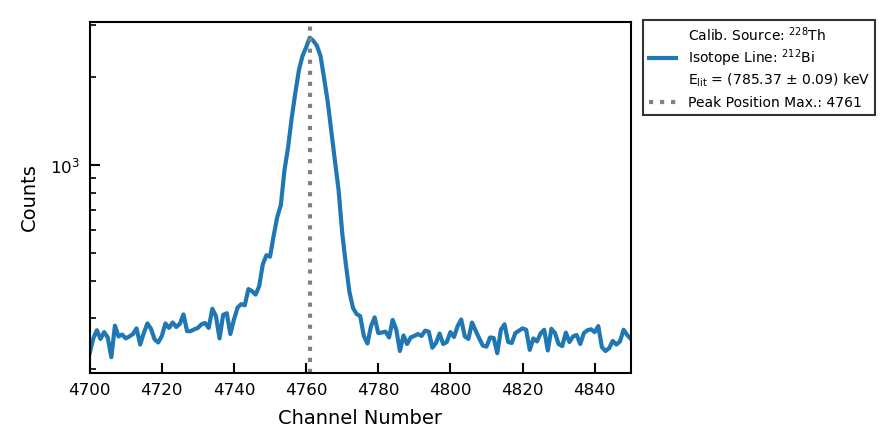

In [52]:
name = 'Bi785'
isotope = '$^{212}$Bi'
e_lit = 785.37 #keV
e_err_lit = 0.09 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4700
upper_channel = 4850
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [53]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [54]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 2.94222234e+04  4.76129715e+03  4.39307859e+00  1.37879678e+00
  2.71236518e+00 -6.42934313e+00 -9.28635202e-02  7.05364300e+02]
Appending data for Bi785 to df_calibration.


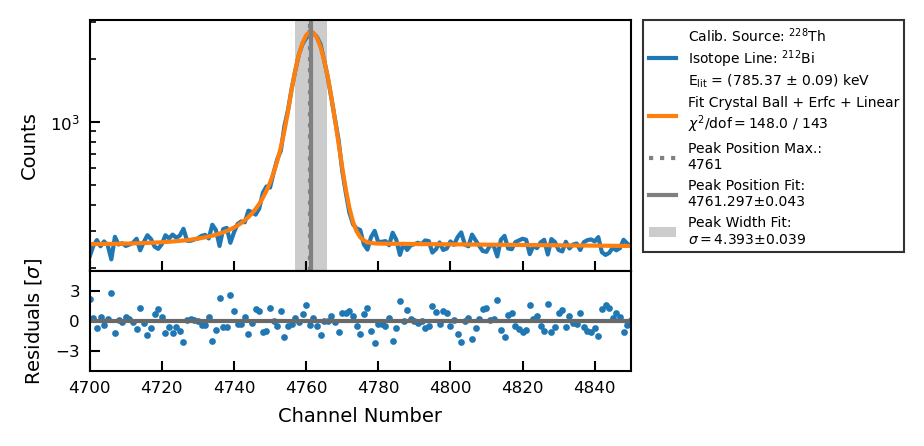

In [55]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 860

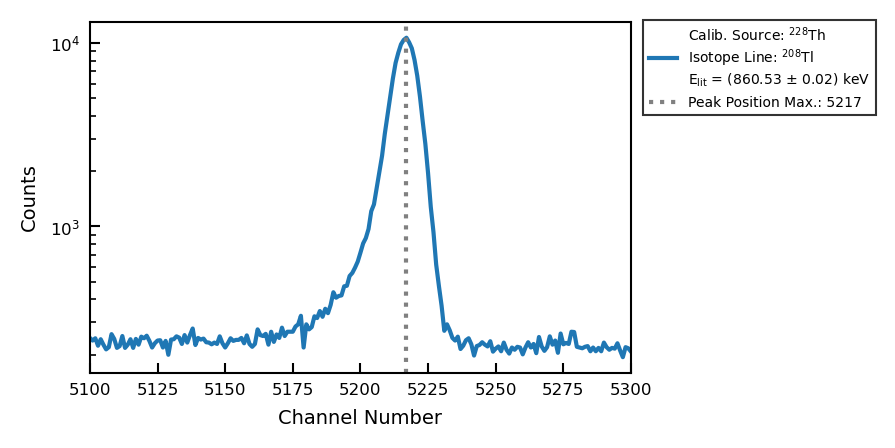

In [56]:
name = 'Tl860'
isotope = '$^{208}$Tl'
e_lit = 860.53 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 5100
upper_channel = 5300
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [57]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [58]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 1.27495355e+05  5.21653025e+03  4.48904095e+00  1.32056389e+00
  3.01732553e+00 -8.12811614e+00 -1.59135556e-01  1.06167903e+03]
Appending data for Tl860 to df_calibration.


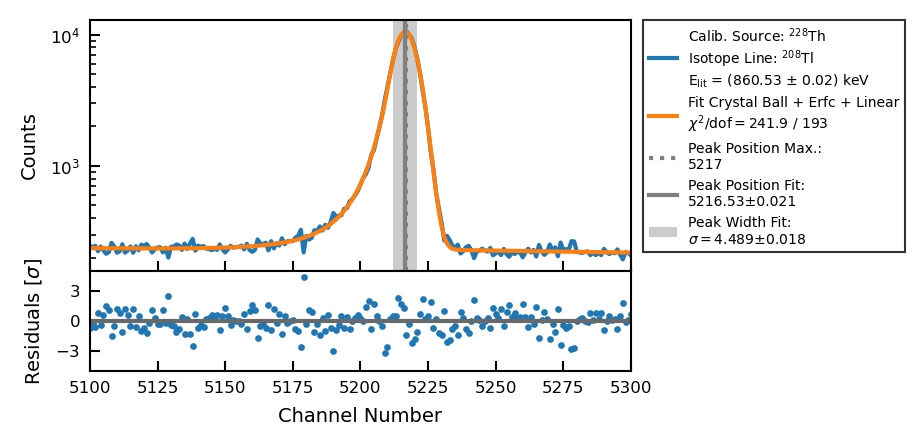

In [59]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 1620

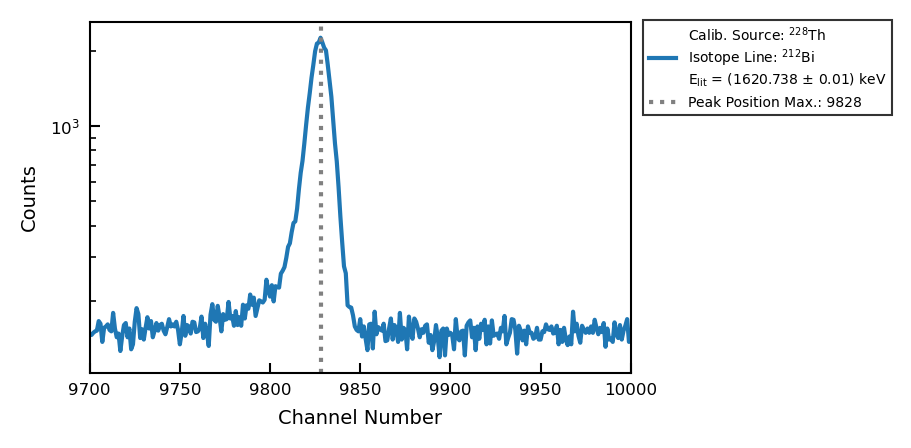

In [60]:
name = 'Bi1620'
isotope = '$^{212}$Bi'
e_lit = 1620.738 #keV
e_err_lit = 0.010 #keV

#######################
## Adjust these values if necessary:
lower_channel = 9700
upper_channel = 10000
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [61]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

'''## Improve guess/limits parameter sigma from Gauss+Step fit
try:
    popt, pcov = curve_fit(gausStepFunc, df_sel_peak.channel, df_sel_peak.counts, 
                           p0=[guess_Gamma, guess_S, guess_P, guess_sigma, (low_med+high_med)/2], 
                           bounds=((limits_Gamma[0], limits_S[0], limits_P[0], limits_sigma[0], 1.1*val_min-0.1*val_max),
                                   (limits_Gamma[1], limits_S[1], limits_P[1], limits_sigma[1], val_max)), 
                           sigma=df_sel_peak.counts_err, maxfev=10000)
    _,_,_,guess_sigma,_ = popt
    limits_sigma[1] = min(5*guess_sigma, limits_sigma[1])
except:
    print('Warning: gausStepFunc failed!')''';

In [62]:
'''df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
plt.plot(df_sel_peak.channel, gausStepFunc(df_sel_peak.channel, *popt), 
         label='Fit Gauss + Erfc')

plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
plt.axvspan(popt[2]-popt[3], popt[2]+popt[3], alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(popt[3],3))+'±'+str(round(np.sqrt(pcov[3,3]),3)))
plt.axvline(popt[2], linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(popt[2],3))+'±'+str(round(np.sqrt(pcov[2,2]),3)))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()''';

In [63]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
'''if np.abs(peak_width-guess_sigma)/peak_width > 0.2:
    print('Warning: Final peak width deviates from gausStepFunc peak width by '+str(round(100*np.abs(peak_width-guess_sigma)/peak_width,1))+' %')'''
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[3.31941415e+04 9.82779433e+03 5.68320656e+00 1.26256112e+00
 2.74631916e+00 1.88783885e+00 5.80502794e-03 9.13691131e+01]
Appending data for Bi1620 to df_calibration.


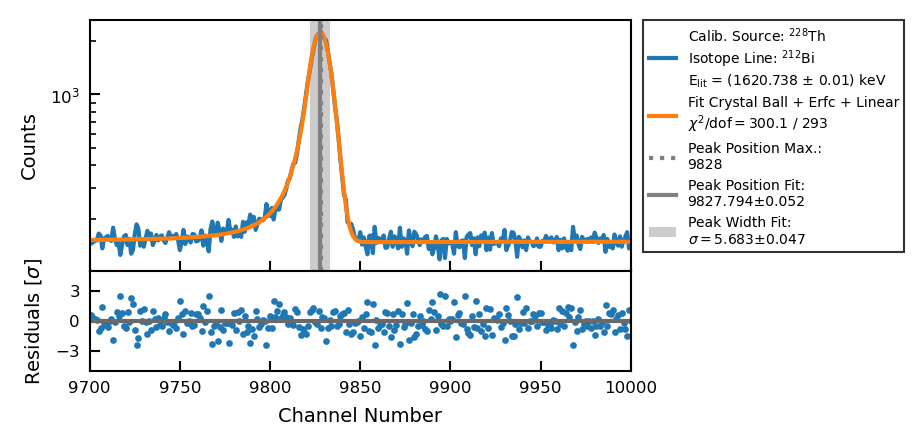

In [64]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 2614

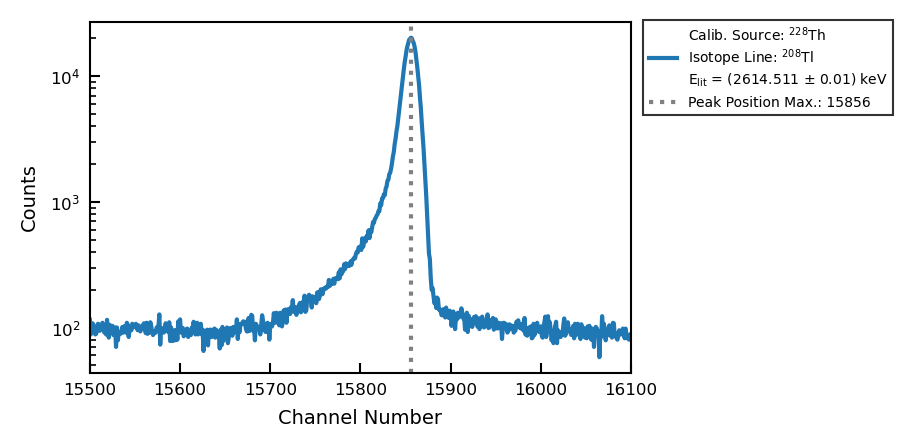

In [65]:
name = 'Tl2614'
isotope = '$^{208}$Tl'
e_lit = 2614.511 #keV
e_err_lit = 0.010 #keV

#######################
## Adjust these values if necessary:
lower_channel = 15500
upper_channel = 16100
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [66]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 100]
limits_n = [0.01, 100]
limits_S = [-2*guess_S,2*guess_S]
limits_m = [-np.inf,0]
limits_q = [-np.inf,+np.inf]

In [67]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 4.16680723e+05  1.58556817e+04  7.05545014e+00  1.26002475e+00
  2.06389624e+00 -1.05000000e+01 -8.79584580e-03  2.39206985e+02]
Appending data for Tl2614 to df_calibration.


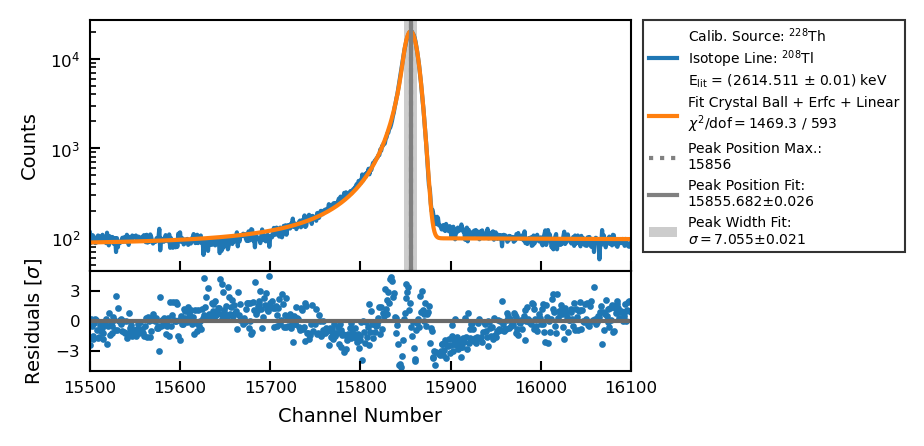

In [68]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

# Quality Checks

In [69]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,Pb238,238.632,0.002,1443.840634,0.006874,3.247863,0.006268,8.188998,1444.0
1,Tl277,277.370,0.020,1678.790493,0.021260,3.320700,0.017064,1.248850,1679.0
2,Pb300,300.089,0.012,1816.904623,0.014394,3.392458,0.012720,1.554642,1817.0
3,Tl583,583.187,0.002,3534.074516,0.014037,3.979598,0.011414,5.665829,3534.0
4,Bi727,727.330,0.010,4408.325214,0.016337,4.248328,0.013716,1.414447,4409.0
5,Bi763,763.450,0.020,4626.752823,0.074983,4.531945,0.062644,1.631794,4627.0
6,Bi785,785.370,0.090,4761.297153,0.043100,4.393079,0.039179,1.035170,4761.0
7,Tl860,860.530,0.020,5216.530250,0.021055,4.489041,0.017860,1.253368,5217.0
8,Bi1620,1620.738,0.010,9827.794331,0.051759,5.683207,0.046948,1.024321,9828.0
9,Tl2614,2614.511,0.010,15855.681740,0.026114,7.055450,0.021179,2.477677,15856.0


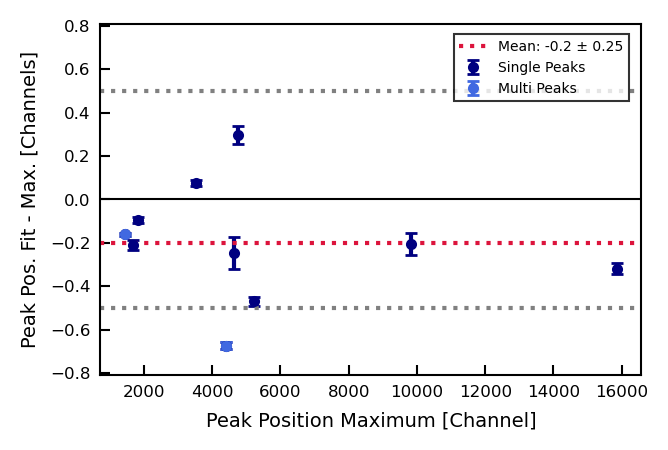

In [70]:
plt.errorbar(df_calibration.channel_max, df_calibration.peak_position-df_calibration.channel_max, 
             yerr = df_calibration.peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'navy', label = 'Single Peaks')
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 df_calibration[df_calibration.name == 'Bi727'].peak_position-df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Bi727'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', 
                 label = 'Multi Peaks')
except:
    pass
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 df_calibration[df_calibration.name == 'Pb238'].peak_position-df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Pb238'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', )
except:
    pass
plt.axhline(y=0, linestyle='-', color = 'k', linewidth = 0.75)
plt.axhline(y=+0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=-0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=+1.0, linestyle='dotted', color = 'gray')
plt.axhline(y=-1.0, linestyle='dotted', color = 'gray')
val_mean_diff = np.mean(df_calibration.peak_position-df_calibration.channel_max)
val_std_diff = np.std(df_calibration.peak_position-df_calibration.channel_max)
plt.axhline(y=val_mean_diff, 
            linestyle='dotted', color = 'crimson', label = 'Mean: '+str(round(val_mean_diff,2))+' ± '+str(round(val_std_diff,2)))
plt.xlabel('Peak Position Maximum [Channel]')
plt.ylabel('Peak Pos. Fit - Max. [Channels]')
val_lim = 1.2*np.max(np.abs(df_calibration.peak_position-df_calibration.channel_max))
plt.ylim(-val_lim, +val_lim)

legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_deviation_lines_max_fit.png', bbox_inches='tight')
plt.show()

In [71]:
thr = 1
outlier_check = np.abs(df_calibration.peak_position-df_calibration.channel_max)>thr
if np.any(outlier_check):
    print('Warning: For the following peaks, the peak max. and fit positions differ by more than 1 Channel and are hence removed from the following analysis: '+str(df_calibration[outlier_check].name.tolist()))
    df_calibration = df_calibration.drop(df_calibration[outlier_check].index.values)
else:
    print('For all peaks, the peak max. and fit positions differ by less than '+str(thr)+' Channel. We hence keep them all for the following analysis.')

For all peaks, the peak max. and fit positions differ by less than 1 Channel. We hence keep them all for the following analysis.


# Calibration

## Linear fit

In [72]:
popt, pcov = curve_fit(linFunc, df_calibration.peak_position, df_calibration.e_lit, 
                       p0=[np.median(df_calibration.e_lit/df_calibration.peak_position), 0], 
                       bounds=((0, -np.inf),
                               (+np.inf, +np.inf)), 
                       sigma=df_calibration.peak_width, maxfev=10000)
cal_CE_a = popt[0]
print(cal_CE_a)
cal_CE_a_err = np.sqrt(pcov[0, 0])
print(cal_CE_a_err)
cal_CE_b = popt[1]
print('')
print(cal_CE_b)
cal_CE_b_err = np.sqrt(pcov[1, 1])
print(cal_CE_b_err)
cal_CE_cov_ab = pcov[0, 1]
cal_CE = (cal_CE_a, cal_CE_b)

cal_EC_a = 1/cal_CE_a
cal_EC_b = -cal_CE_b/cal_CE_a
cal_EC = (cal_EC_a, cal_EC_b)

with open(filename_suffix_save+'_calibration_parameters.txt', 'w') as writer:
    writer.write("cal_CE_a"+"\n")
    writer.write(str(cal_CE_a)+"\n")
    writer.write("cal_CE_a_err"+"\n")
    writer.write(str(cal_CE_a_err)+"\n")
    writer.write("cal_CE_b"+"\n")
    writer.write(str(cal_CE_b)+"\n")
    writer.write("cal_CE_b_err"+"\n")
    writer.write(str(cal_CE_b_err)+"\n")
    writer.write("cal_CE_cov_ab"+"\n")
    writer.write(str(cal_CE_cov_ab)+"\n")

0.16485455420310968
6.64109999521728e-06

0.5881101870063857
0.03253800882074557


In [73]:
reconstr_e = linFunc(df_calibration.peak_position, *cal_CE)
df_calibration['reconstr_e'] = reconstr_e
reconstr_e_err = np.sqrt(cal_CE_b_err**2 + (cal_CE_a_err*df_calibration.peak_position)**2 + 2*(df_calibration.peak_position)*cal_CE_cov_ab)
residuals_e = reconstr_e - df_calibration.e_lit
residuals_e_err = np.sqrt(reconstr_e_err**2 + (df_calibration.e_err_lit)**2)
print(np.mean(residuals_e))

-0.0010607124159975


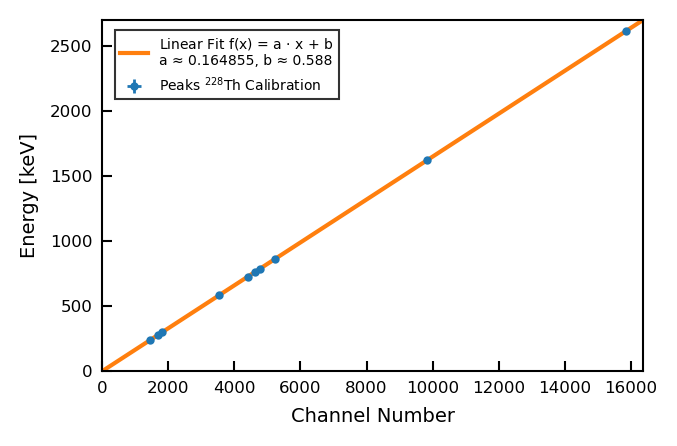

In [74]:
plt.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{228}$Th Calibration', linewidth=1)
plt.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],6))+', b ≈ '+str(round(popt[1],3)))
plt.xlabel('Channel Number')
plt.ylabel('Energy [keV]')
#plt.xscale('log'); plt.yscale('log');
plt.xlim(0, 16383)
plt.ylim(0, linFunc(16383, *popt))
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit.png', bbox_inches='tight')
plt.show()

In [75]:
chi2 = np.sum(residuals_e**2 / residuals_e_err**2)
dof = len(residuals_e)-len(popt)

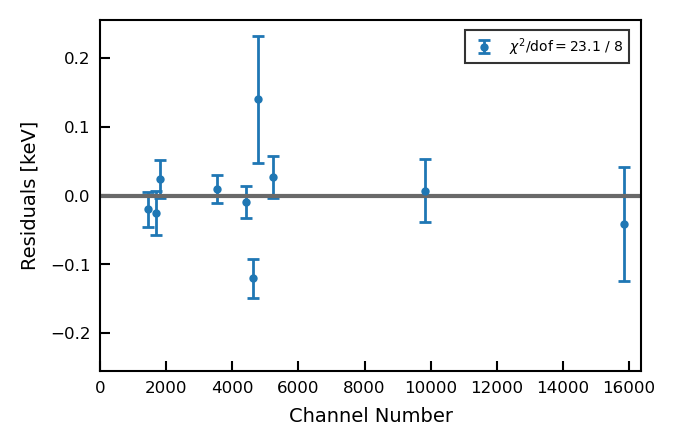

In [76]:
plt.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.xlabel('Channel Number')
plt.ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
plt.xlim(0, 16383)
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

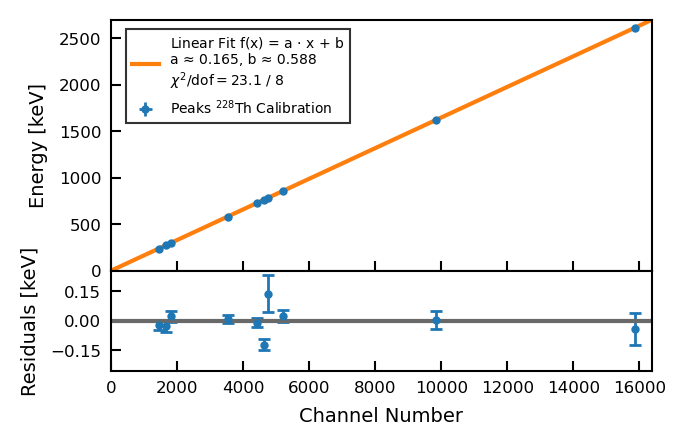

In [77]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{228}$Th Calibration', linewidth=1)
ax0.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],3))+', b ≈ '+str(round(popt[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy [keV]')
ax0.set_ylim(0, linFunc(16383, *popt))

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
plt.xlim(0, 16383)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

## Spectrum

In [78]:
isotope_list = []
for i in df_calibration['name']:
    if i.find('Tl') > -1:
        isotope_list.append('$^{208}$Tl')
    elif i.find('Bi') > -1:
        isotope_list.append('$^{212}$Bi')
    elif i.find('Pb') > -1:
        isotope_list.append('$^{212}$Pb')
df_calibration['isotope'] = isotope_list

In [79]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max,reconstr_e,isotope
0,Pb238,238.632,0.002,1443.840634,0.006874,3.247863,0.006268,8.188998,1444.0,238.611814,$^{212}$Pb
1,Tl277,277.370,0.020,1678.790493,0.021260,3.320700,0.017064,1.248850,1679.0,277.344368,$^{208}$Tl
2,Pb300,300.089,0.012,1816.904623,0.014394,3.392458,0.012720,1.554642,1817.0,300.113112,$^{212}$Pb
3,Tl583,583.187,0.002,3534.074516,0.014037,3.979598,0.011414,5.665829,3534.0,583.196389,$^{208}$Tl
4,Bi727,727.330,0.010,4408.325214,0.016337,4.248328,0.013716,1.414447,4409.0,727.320598,$^{212}$Bi
5,Bi763,763.450,0.020,4626.752823,0.074983,4.531945,0.062644,1.631794,4627.0,763.329384,$^{212}$Bi
6,Bi785,785.370,0.090,4761.297153,0.043100,4.393079,0.039179,1.035170,4761.0,785.509630,$^{212}$Bi
7,Tl860,860.530,0.020,5216.530250,0.021055,4.489041,0.017860,1.253368,5217.0,860.556879,$^{208}$Tl
8,Bi1620,1620.738,0.010,9827.794331,0.051759,5.683207,0.046948,1.024321,9828.0,1620.744763,$^{212}$Bi
9,Tl2614,2614.511,0.010,15855.681740,0.026114,7.055450,0.021179,2.477677,15856.0,2614.469455,$^{208}$Tl


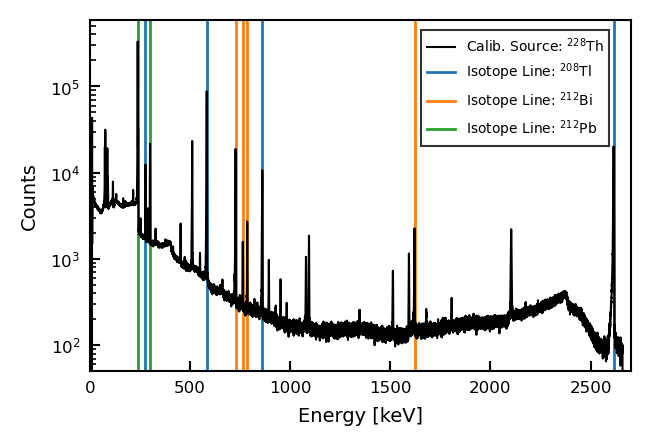

In [80]:
plt.plot(linFunc(df.channel, *cal_CE), df.counts, color = 'black', linewidth = 0.75, label = 'Calib. Source: $^{228}$Th')
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{208}$Tl'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C0', label = 'Isotope Line: $^{208}$Tl', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C0', zorder = 0, linewidth = 1)
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{212}$Bi'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C1', label = 'Isotope Line: $^{212}$Bi', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C1', zorder = 0, linewidth = 1)
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{212}$Pb'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C2', label = 'Isotope Line: $^{212}$Pb', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C2', zorder = 0, linewidth = 1)
plt.yscale('log')
plt.xlim(0,linFunc(16383, *cal_CE))
plt.ylim(bottom = 50)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(0.6,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_spectrum_lines_marked.png', bbox_inches='tight')
plt.show()

# Resolution

In [81]:
ratio_width_fitlit = cal_CE_a*df_calibration.peak_width/df_calibration.e_err_lit
ratio_width_fitlit

0    267.712478
1     27.371630
2     46.605183
3    328.027418
4     70.035617
5     37.355587
6      8.046878
7     37.001942
8     93.690248
9    116.312309
dtype: float64

In [82]:
df_calibration.peak_width

0    3.247863
1    3.320700
2    3.392458
3    3.979598
4    4.248328
5    4.531945
6    4.393079
7    4.489041
8    5.683207
9    7.055450
Name: peak_width, dtype: float64

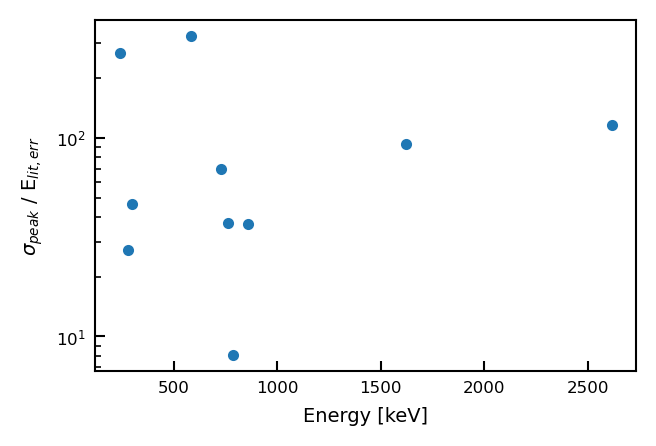

In [83]:
plt.errorbar(df_calibration.e_lit, ratio_width_fitlit, 
            fmt = 'o', ms = 3)
#plt.axhline(y = 20, color = 'gray')
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('$\sigma_{peak}$ / E$_{lit, err}$')
plt.show()

In [84]:
## Remove lines where ratio_width_fitlit<20
#reconstr_e = reconstr_e[ratio_width_fitlit>20]
#reconstr_e_err = reconstr_e_err[ratio_width_fitlit>20]

In [85]:
rel_resol = cal_CE_a*df_calibration.peak_width / reconstr_e
rel_resol_err = rel_resol*np.sqrt((reconstr_e_err/reconstr_e)**2+(cal_CE_a_err/cal_CE_a)**2+(df_calibration.peak_width_unc**2/df_calibration.peak_width))

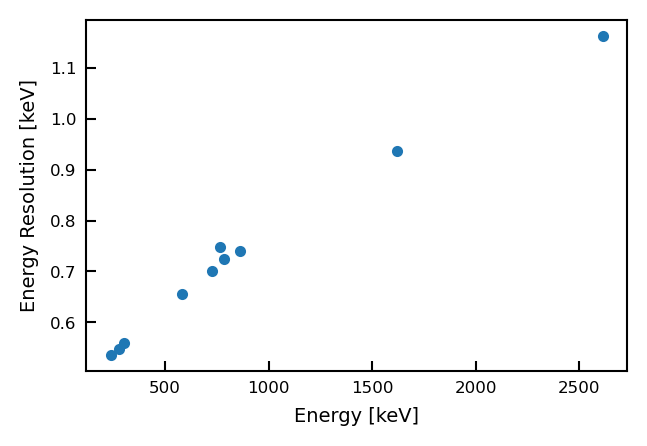

In [86]:
plt.errorbar(df_calibration.e_lit, rel_resol*reconstr_e, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3)
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [keV]')
plt.show()

In [87]:
def relresolFunc(E, a,b,c):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

In [88]:
popt, pcov = curve_fit(relresolFunc, df_calibration.e_lit, rel_resol, 
                       p0=[0.1, 0.1, 0.1], 
                       bounds=((0, 0, 0),
                               (+np.inf, +np.inf, +np.inf)), 
                       sigma=rel_resol_err, maxfev=10000)
print(popt[0])
print(popt[1])
print(popt[2])
residuals = relresolFunc(df_calibration.e_lit, *popt) - rel_resol

0.1888454720505907
0.0004058603728772862
1.4946340175567622e-08


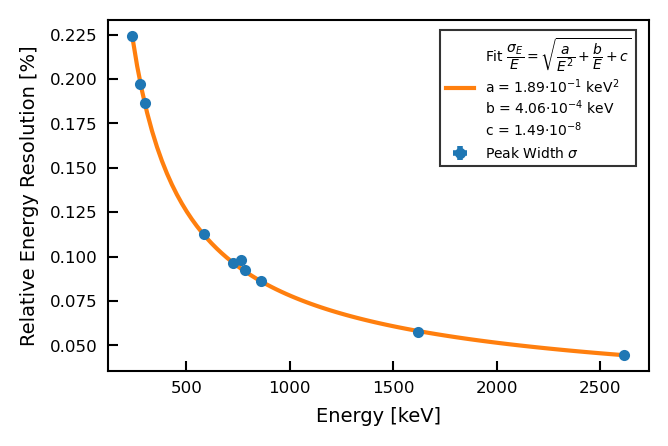

In [89]:
plt.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt[2],2))+'$\cdot 10^{-8}$')
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Relative Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit.png', bbox_inches='tight')
plt.show()

# Other Stuff

In [90]:
linFunc(np.array([100, 2700]), *cal_EC)

array([  603.02786474, 16374.50601751])

In [91]:
linFunc(np.array([0, 16383]), *cal_CE)

array([5.88110187e-01, 2.70140027e+03])